# The Stanford Sentiment Treebank 
The Stanford Sentiment Treebank consists of sentences from movie reviews and human annotations of their sentiment. The task is to predict the sentiment of a given sentence. We use the two-way (positive/negative) class split, and use only sentence-level labels.

In [1]:
from IPython.display import display, Markdown
with open('../../doc/env_variables_setup.md', 'r') as fh:
    content = fh.read()
display(Markdown(content))

Environment variables that need to be defined:   
`export DIR_PROJ=your_path_git_repository`  
`export PYTHONPATH=$DIR_PROJ/src`  
`export PATH_TENSORBOARD=your_path_tensorboard`  
`export PATH_DATASETS=your_path_datasets`  
`export PROJECT_ID=your_gcp_project_id`  
`export BUCKET_NAME=your_gcp_gs_bucket_name`  
`export REGION=your_region`  
`export PATH_SAVE_MODEL=your_path_to_save_model` 

- Use local Jupyter Lab 
    - you need to have the `jupyter-notebook` Anaconda python environment created [link](local_jupyter_lab_installation.md) 
    - you need to have the `jupyter-notebook` Anaconda python environment activated [link](local_jupyter_lab_installation.md) 
    - then define the environment variables above (copy and paste) 
    - you need to have the `env_multilingual_class` Anaconda python environment created [link](local_jupyter_lab_installation.md)  
    - start Jupyter Lab:  `jupyter lab` 
    - open a Jupyter Lab notebook from `notebook/` 
     - clone this repositiory: `git clone https://github.com/tarrade/proj_multilingual_text_classification.git`
    - choose the proper Anaconda python environment:  `Python [conda env:env_multilingual_class]` [link](conda_env.md) 
    - clone this repositiory: `git clone https://github.com/tarrade/proj_multilingual_text_classification.git`


- Use GCP Jupyter Lab 
    - Go on GCP
    - open a Cloud Shell
    - `ssh-keygen -t rsa -b 4096 -C firstName_lastName`
    - `cp .ssh/id_rsa.pub .`
    - use Cloud Editor to edit this file `id_rsa.pub` and copy the full content
    - Go on Compute Engine -> Metadata
    - Click SSH Keys
    - Click Edit
    - Click + Add item, copy the content of `id_rsa.pub`
    - You should see firstName_lastName of the left
    - Click Save
    - you need to start a AI Platform instance 
    - open a Jupyter Lab terminal and got to `/home/gcp_user_name/`
    - clone this repositiory: `git clone https://github.com/tarrade/proj_multilingual_text_classification.git`
    - then `cd proj_multilingual_text_classification/`
    - create the Anacond Python environment `conda env create -f env/environment.yml`
    - create a file `config.sh` in `/home` with the following information: 
    ```
    #!/bin/bash
    
    echo "applying some configuration ..."
    git config --global user.email user_email
    git config --global user.name user_name
    git config --global credential.helper store
        
    # Add here the enviroment variables from above below
    # [EDIT ME]
    export DIR_PROJ=your_path_git_repository
    export PYTHONPATH=$DIR_PROJ/src
  
    cd /home/gcp_user_name/
    
    conda activate env_multilingual_class

    export PS1='\[\e[91m\]\u@:\[\e[32m\]\w\[\e[0m\]$'
    ```
    - Got to AI Platform Notebook, select your instance and click "Reset".
    - Wait and reshreh you Web browser with the Notebook


## Import Packages

In [2]:
import tensorflow as tf
import tensorflow_datasets

from tensorflow.keras.utils import to_categorical

from transformers import (
    BertConfig,
    BertTokenizer,
    TFBertModel,
    TFBertForSequenceClassification,
    glue_convert_examples_to_features,
    glue_processors
)

from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import seaborn as sns

from google.cloud import storage

import math
import numpy as np
import os
import glob
import time
from datetime import timedelta
import shutil
from datetime import datetime

import pandas as pd

## Check configuration

In [3]:
print(tf.version.GIT_VERSION, tf.version.VERSION)

unknown 2.1.0


In [4]:
print(tf.keras.__version__)

2.2.4-tf


In [5]:
gpus = tf.config.list_physical_devices('GPU')
if len(gpus)>0:
    for gpu in gpus:
        print('Name:', gpu.name, '  Type:', gpu.device_type)
else:
    print('No GPU available !!!!')

No GPU available !!!!


## Define Paths

In [6]:
try:
    data_dir=os.environ['PATH_DATASETS']
except KeyError:
    print('missing PATH_DATASETS')
try:   
    tensorboard_dir=os.environ['PATH_TENSORBOARD']
except KeyError:
    print('missing PATH_TENSORBOARD')
try:   
    savemodel_dir=os.environ['PATH_SAVE_MODEL']
except KeyError:
    print('missing PATH_SAVE_MODEL')

## Import local packages

In [7]:
import preprocessing.preprocessing as pp
import utils.model_metrics as mm

In [8]:
import importlib
importlib.reload(pp);
importlib.reload(mm);

## Loading a data from Tensorflow Datasets

In [9]:
data, info = tensorflow_datasets.load(name='glue/sst2',
                                      data_dir=data_dir,
                                      with_info=True)

INFO:absl:Overwrite dataset info from restored data version.
INFO:absl:Reusing dataset glue (/home/vera_luechinger/data/glue/sst2/1.0.0)
INFO:absl:Constructing tf.data.Dataset for split None, from /home/vera_luechinger/data/glue/sst2/1.0.0


### Checking baics info from the metadata

In [10]:
info

tfds.core.DatasetInfo(
    name='glue',
    version=1.0.0,
    description='GLUE, the General Language Understanding Evaluation benchmark
(https://gluebenchmark.com/) is a collection of resources for training,
evaluating, and analyzing natural language understanding systems.

            The Stanford Sentiment Treebank consists of sentences from movie reviews and
            human annotations of their sentiment. The task is to predict the sentiment of a
            given sentence. We use the two-way (positive/negative) class split, and use only
            sentence-level labels.',
    homepage='https://nlp.stanford.edu/sentiment/index.html',
    features=FeaturesDict({
        'idx': tf.int32,
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
        'sentence': Text(shape=(), dtype=tf.string),
    }),
    total_num_examples=70042,
    splits={
        'test': 1821,
        'train': 67349,
        'validation': 872,
    },
    supervised_keys=None,
    citation="""@

In [11]:
pp.print_info_dataset(info)

Labels:
      ['negative', 'positive']

Number of label:
      2

Structure of the data:
      dict_keys(['sentence', 'label', 'idx'])

Number of entries:
   Train dataset: 67349
   Test dataset:  1821
   Valid dataset: 872



### Checking basic info from the metadata

In [12]:
data

{'test': <DatasetV1Adapter shapes: {idx: (), label: (), sentence: ()}, types: {idx: tf.int32, label: tf.int64, sentence: tf.string}>,
 'train': <DatasetV1Adapter shapes: {idx: (), label: (), sentence: ()}, types: {idx: tf.int32, label: tf.int64, sentence: tf.string}>,
 'validation': <DatasetV1Adapter shapes: {idx: (), label: (), sentence: ()}, types: {idx: tf.int32, label: tf.int64, sentence: tf.string}>}

In [13]:
data.keys()

dict_keys(['test', 'train', 'validation'])

In [14]:
pp.print_info_data(data['train'])

# Structure of the data:

   <DatasetV1Adapter shapes: {idx: (), label: (), sentence: ()}, types: {idx: tf.int32, label: tf.int64, sentence: tf.string}>

# Output shape of one entry:
   {'idx': TensorShape([]), 'label': TensorShape([]), 'sentence': TensorShape([])}

# Output types of one entry:
   {'idx': tf.int32, 'label': tf.int64, 'sentence': tf.string}

# Output typesof one entry:
   {'idx': <class 'tensorflow.python.framework.ops.Tensor'>, 'label': <class 'tensorflow.python.framework.ops.Tensor'>, 'sentence': <class 'tensorflow.python.framework.ops.Tensor'>}
 

# Shape of the data:

   (67349,)
   ---> 67349 entries
   ---> 1 dim
        dict structure
           dim: 3
           [idx       / label     / sentence ]
           [()        / ()        / ()       ]
           [int32     / int64     / bytes    ]


# Examples of data:
{'idx': 16399,
 'label': 0,
 'sentence': b'for the uninitiated plays better on video with the sound '}
{'idx': 1680,
 'label': 0,
 'sentence': b'like a g

## Define parameters of the model

In [15]:
# extract parameters
size_train_dataset = info.splits['train'].num_examples
size_test_dataset = info.splits['test'].num_examples
size_valid_dataset = info.splits['validation'].num_examples
number_label = info.features["label"].num_classes

print('Dataset size:          {:6}/{:6}/{:6}'.format(size_train_dataset, size_test_dataset, size_valid_dataset))

Dataset size:           67349/  1821/   872


## Data analysis

### Extraction data and creating dataframes

In [16]:
def extraction(feature):
    #print('feature:',feature['sentence'])
    
    return feature['sentence'], feature['label']

In [17]:
np_train = np.array(list(data['train'].map(extraction).as_numpy_iterator()))
np_test = np.array(list(data['test'].map(extraction).as_numpy_iterator()))
np_valid = np.array(list(data['validation'].map(extraction).as_numpy_iterator()))

In [18]:
df_train = pd.DataFrame(data=np_train, columns=['sentence', 'label'])
df_test = pd.DataFrame(data=np_test, columns=['sentence', 'label'])
df_valid = pd.DataFrame(data=np_valid, columns=['sentence', 'label'])

In [19]:
df_train['text']=df_train['sentence'].apply(lambda x: x.decode("utf-8"))
df_test['text']=df_test['sentence'].apply(lambda x: x.decode("utf-8"))
df_valid['text']=df_valid['sentence'].apply(lambda x: x.decode("utf-8"))

In [20]:
df_train['label']=df_train['label'].astype('int32')
df_test['label']=df_test['label'].astype('int32')
df_valid['label']=df_valid['label'].astype('int32')

In [21]:
df_train.pop('sentence')
df_test.pop('sentence')
df_valid.pop('sentence');

In [22]:
df_train['word_count'] = df_train['text'].apply(lambda txt: len(txt.split(' ')))
df_test['word_count'] = df_test['text'].apply(lambda txt: len(txt.split(' ')))
df_valid['word_count'] = df_valid['text'].apply(lambda txt: len(txt.split(' ')))

### Structure exploration

In [23]:
df_train.columns

Index(['label', 'text', 'word_count'], dtype='object')

In [24]:
df_train.dtypes

label          int32
text          object
word_count     int64
dtype: object

### Basics exploration

In [25]:
len(df_train)

67349

In [26]:
len(df_test)

1821

In [27]:
len(df_valid)

872

In [28]:
df_train.head()

,label,text,word_count
0,0,for the uninitiated plays better on video with...,11
1,0,like a giant commercial for universal studios ...,16
2,1,company once again dazzle and delight us,8
3,1,'s no surprise that as a director washington d...,22
4,0,", this cross-cultural soap opera is painfully ...",12


In [29]:
df_train.isnull().sum()

label         0
text          0
word_count    0
dtype: int64

In [30]:
df_test.isnull().sum()

label         0
text          0
word_count    0
dtype: int64

In [31]:
df_valid.isnull().sum()

label         0
text          0
word_count    0
dtype: int64

In [32]:
df_train['label'].value_counts(dropna=False)

1    37569
0    29780
Name: label, dtype: int64

In [33]:
df_test['label'].value_counts(dropna=False)

-1    1821
Name: label, dtype: int64

In [34]:
df_valid['label'].value_counts(dropna=False)

1    444
0    428
Name: label, dtype: int64

In [35]:
df_train['word_count'].describe()

count    67349.000000
mean        10.409553
std          8.073806
min          2.000000
25%          4.000000
50%          8.000000
75%         14.000000
max         53.000000
Name: word_count, dtype: float64

In [36]:
df_test['word_count'].describe()

count    1821.000000
mean       19.233937
std         8.922386
min         2.000000
25%        12.000000
50%        18.000000
75%        25.000000
max        56.000000
Name: word_count, dtype: float64

In [37]:
df_valid['word_count'].describe()

count    872.000000
mean      20.548165
std        8.763900
min        3.000000
25%       14.000000
50%       20.000000
75%       27.000000
max       48.000000
Name: word_count, dtype: float64

### Visualization of the data

In [38]:
#plt.style.use('dark_background')

In [39]:
plt.rcParams['figure.figsize'] = [10, 8]

Text(0, 0.5, 'Document')

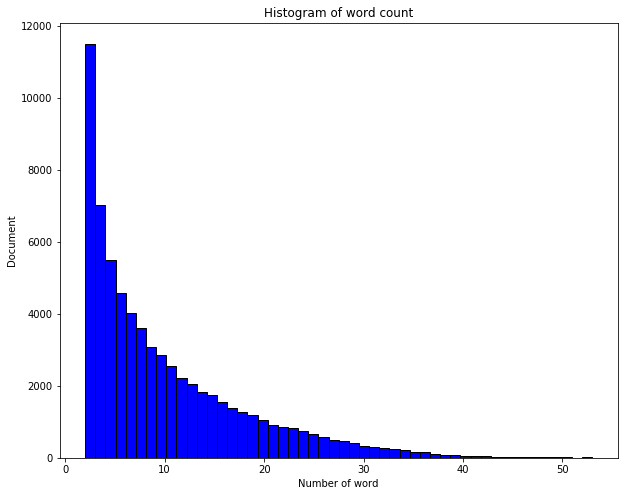

In [40]:
# matplotlib histogram
plt.hist(df_train['word_count'], color = 'blue', edgecolor = 'black',bins = int(50));
# Add labels
plt.title('Histogram of word count')
plt.xlabel('Number of word')
plt.ylabel('Document')

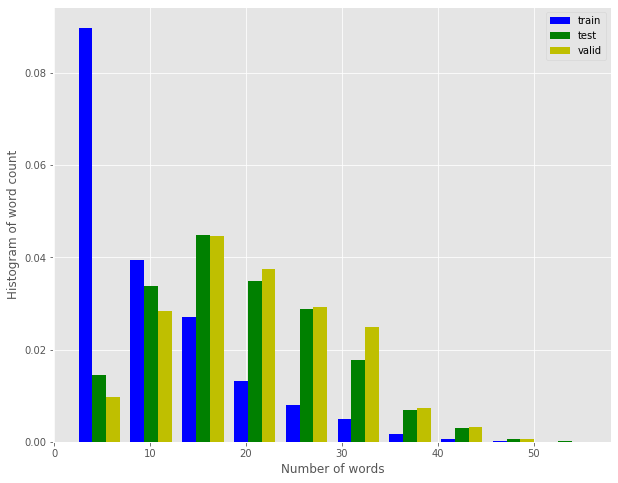

In [41]:
plt.style.use('ggplot')
fig, ax1 = plt.subplots()
ax1.hist([df_train['word_count'],df_test['word_count'],df_valid['word_count']],color=['b','g', 'y'], label=['train', 'test', 'valid'], density=True)
ax1.set_ylabel('Histogram of word count')
ax1.set_xlabel('Number of words')
plt.legend(loc='upper right')
plt.show()

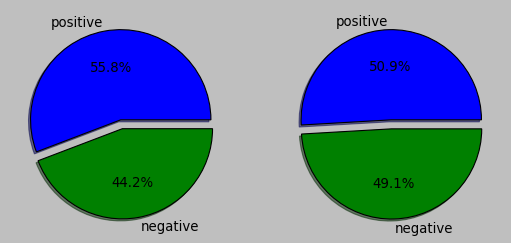

In [42]:
plt.style.use('classic')
explode = (0, 0.1) 
# Make figure and axes
fig, axs = plt.subplots(1, 2)

# A standard pie plot
labels = info.features["label"].names[list(df_train['label'].value_counts(dropna=False).index)[0]], info.features["label"].names[list(df_train['label'].value_counts(dropna=False).index)[1]]
fracs = list(df_train['label'].value_counts(dropna=False))
axs[0].pie(fracs, labels=labels, explode=explode, autopct='%1.1f%%', shadow=True);

# A standard pie plot
labels = info.features["label"].names[list(df_valid['label'].value_counts(dropna=False).index)[0]], info.features["label"].names[list(df_valid['label'].value_counts(dropna=False).index)[1]]
fracs = list(df_valid['label'].value_counts(dropna=False))
axs[1].pie(fracs, labels=labels, explode=explode, autopct='%1.1f%%', shadow=True);

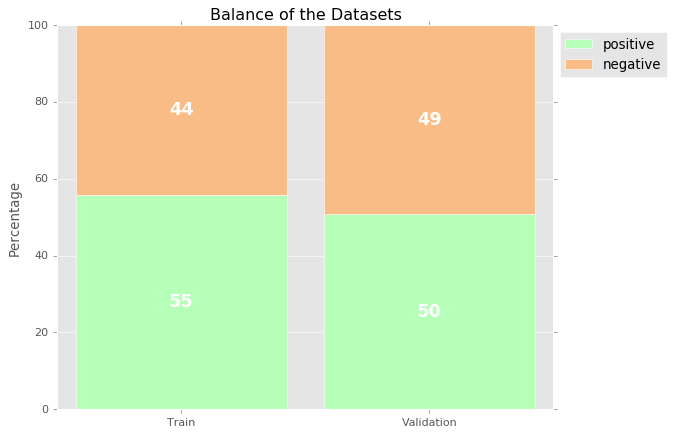

In [43]:
# Data
#plt.style.use('dark_background')
plt.style.use('ggplot')

labels_train = info.features["label"].names[list(df_train['label'].value_counts(dropna=False).index)[0]], info.features["label"].names[list(df_train['label'].value_counts(dropna=False).index)[1]]
labels_valid = info.features["label"].names[list(df_valid['label'].value_counts(dropna=False).index)[0]], info.features["label"].names[list(df_train['label'].value_counts(dropna=False).index)[1]]
fracs_train = list(df_train['label'].value_counts(dropna=False))
fracs_valid = list(df_valid['label'].value_counts(dropna=False))

r = [0,1]
raw_data = {'greenBars': [fracs_train[0],fracs_valid[0]], 'orangeBars': [fracs_train[1],fracs_valid[1]]}
df = pd.DataFrame(raw_data)
 
# From raw value to percentage
totals = [i+j for i,j in zip(df['greenBars'], df['orangeBars'])]
greenBars = [i / j * 100 for i,j in zip(df['greenBars'], totals)]
orangeBars = [i / j * 100 for i,j in zip(df['orangeBars'], totals)]
 
# plot
barWidth = 0.85
names = ('Train', 'Validation')
# Create green Bars
ax1 = plt.bar(r, greenBars, color='#b5ffb9', edgecolor='white', width=barWidth, label="positive")
# Create orange Bars
ax2 = plt.bar(r, orangeBars, bottom=greenBars, color='#f9bc86', edgecolor='white', width=barWidth, label="negative")

for r1, r2 in zip(ax1, ax2):
    h1 = r1.get_height()
    h2 = r2.get_height()
    plt.text(r1.get_x() + r1.get_width() / 2., h1 / 2., "%d" % h1, ha="center", va="center", color="white", fontsize=16, fontweight="bold")
    plt.text(r2.get_x() + r2.get_width() / 2., h1 + h2 / 2., "%d" % h2, ha="center", va="center", color="white", fontsize=16, fontweight="bold")

# Custom x axis
plt.xticks(r, names)
plt.title("Balance of the Datasets")
plt.ylabel("Percentage")
plt.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1)
 
# Show graphic
plt.show()

### Selection

In [44]:
q=0.95

Minimum word count required to include all words in 95.0% of the reviews: 27.0


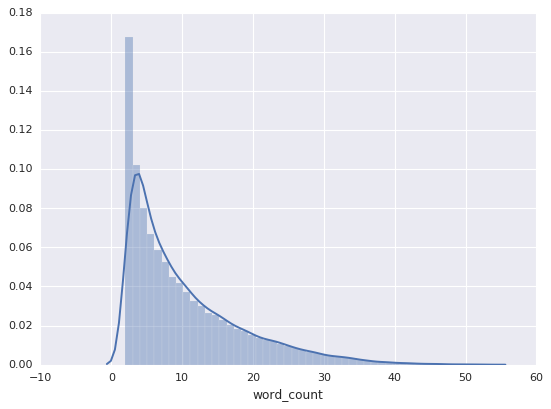

In [45]:
plt.style.use('seaborn')

x = df_train['word_count']
sns.distplot(x, hist=True);
#sns.distplot(x, hist=True, rug=True);
print('Minimum word count required to include all words in {}% of the reviews: {}'.format(q*100, x.quantile(q)))

Minimum word count required to include all words in 95.0% of the reviews: 35.0


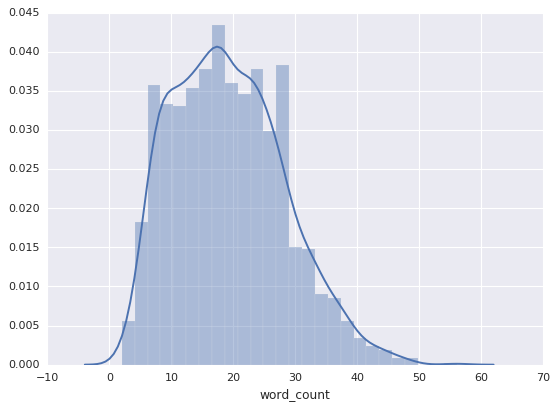

In [46]:
plt.style.use('seaborn')

x = df_test['word_count']
sns.distplot(x, hist=True);
#sns.distplot(x, hist=True, rug=True);
print('Minimum word count required to include all words in {}% of the reviews: {}'.format(q*100, x.quantile(q)))

Minimum word count required to include all words in 95.0% of the reviews: 35.44999999999993


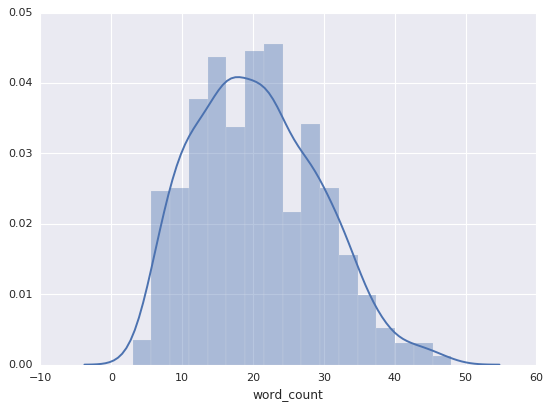

In [47]:
plt.style.use('seaborn')

x = df_valid['word_count']
sns.distplot(x, hist=True);
print('Minimum word count required to include all words in {}% of the reviews: {}'.format(q*100, x.quantile(q)))

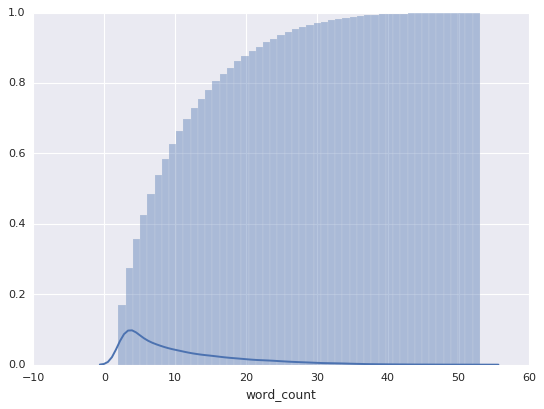

In [48]:
plt.style.use('seaborn')
sns.distplot(df_train['word_count'], hist_kws={'cumulative': True});

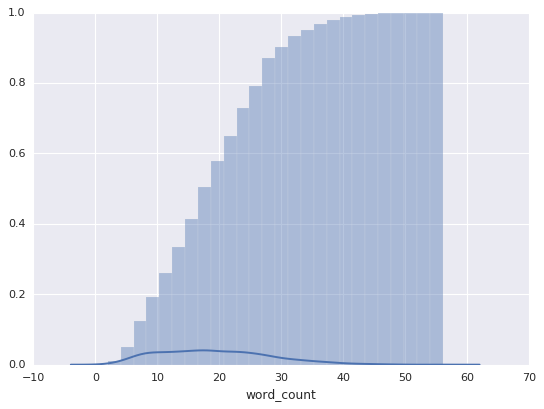

In [49]:
plt.style.use('seaborn')
sns.distplot(df_test['word_count'], hist_kws={'cumulative': True});

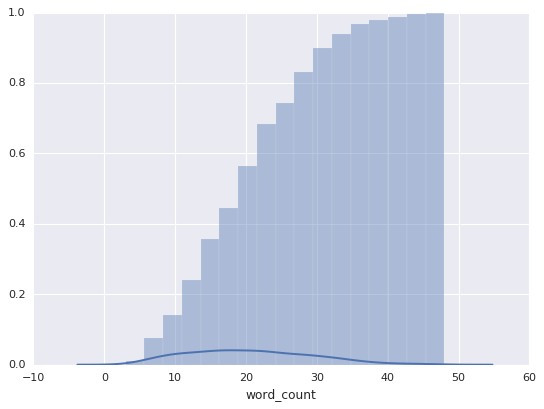

In [50]:
plt.style.use('seaborn')
sns.distplot(df_valid['word_count'], hist_kws={'cumulative': True});

In [51]:
def fraction_data(df):
    tot=len(df)
    for size in [2, 5, 10, 20, 27]:
        nb=len(df[df['word_count'] <size])
        print('threshold: {:10d}  amount of data selected: {:10d} percentage of the data selected: {:.2f} %'.format(size, nb , nb/tot*100))

In [52]:
fraction_data(df_train)

threshold:          2  amount of data selected:          0 percentage of the data selected: 0.00 %
threshold:          5  amount of data selected:      18542 percentage of the data selected: 27.53 %
threshold:         10  amount of data selected:      39336 percentage of the data selected: 58.41 %
threshold:         20  amount of data selected:      58015 percentage of the data selected: 86.14 %
threshold:         27  amount of data selected:      63624 percentage of the data selected: 94.47 %


In [53]:
fraction_data(df_test)

threshold:          2  amount of data selected:          0 percentage of the data selected: 0.00 %
threshold:          5  amount of data selected:         21 percentage of the data selected: 1.15 %
threshold:         10  amount of data selected:        289 percentage of the data selected: 15.87 %
threshold:         20  amount of data selected:        994 percentage of the data selected: 54.59 %
threshold:         27  amount of data selected:       1440 percentage of the data selected: 79.08 %


In [54]:
fraction_data(df_valid)

threshold:          2  amount of data selected:          0 percentage of the data selected: 0.00 %
threshold:          5  amount of data selected:          3 percentage of the data selected: 0.34 %
threshold:         10  amount of data selected:         87 percentage of the data selected: 9.98 %
threshold:         20  amount of data selected:        418 percentage of the data selected: 47.94 %
threshold:         27  amount of data selected:        647 percentage of the data selected: 74.20 %
